# Foodformer: Vision Transformer trained on the Food101 dataset

In [ ]:
!pip install -Uqq datasets transformers[torch] torchmetrics pytorch-lightning wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.0/727.0 kB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from functools import partial
from torchvision.datasets import Food101
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTImageProcessor.from_pretrained(model_name_or_path)

preprocessor = partial(feature_extractor, return_tensors='pt')

train_ds = Food101(
    root="food101_dataset", split='train', transform=preprocessor,
    download=True
)
test_ds = Food101(
    root="food101_dataset", split='test', transform=preprocessor,
)

labels = train_ds.classes
print(f"Classes examples: {labels[:10]}")

100%|██████████| 4996278331/4996278331 [04:34<00:00, 18194005.36it/s]


Extracting food101_dataset/food-101.tar.gz to food101_dataset
Classes examples: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ViTDataset(Dataset):
    """Package images pixel values and labels into a dictionary."""
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self) -> int:
        """In PyTorch datasets have to override the length method."""
        return len(self.dataset)

    def __getitem__(self, index: int) -> dict:
        """This method defines how to feed the data during model training."""
        inputs_and_labels = dict()
        inputs_and_labels['pixel_values'] = self.dataset[index][0]["pixel_values"][0]
        inputs_and_labels['labels'] = self.dataset[index][1]
        return inputs_and_labels

train_dataset = ViTDataset(train_ds)
test_dataset = ViTDataset(test_ds)

# Optional: work with a subset of the data for development
# train_dataset = torch.utils.data.Subset(train_dataset, list(range(10000)))
# test_dataset = torch.utils.data.Subset(test_dataset, list(range(1000)))

# Create a dataloader object to chunk the datasets into batches
training_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
testing_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

Label: churros


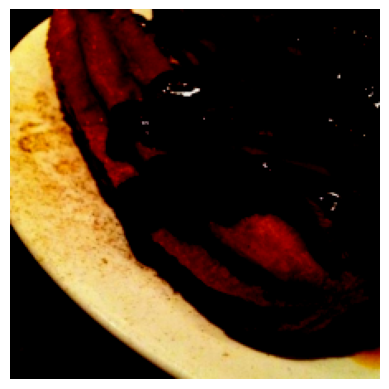

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sample = test_dataset[7]
image = sample["pixel_values"].numpy()
if image.shape[0] == 3:
    # Convert image from "Channel first" to "Channel Last"
    image = np.moveaxis(image, 0, -1)

print(f"Label: {labels[sample['labels']]}")


plt.axis("off")
plt.imshow(image)

In [ ]:
import pytorch_lightning as pl
from torch.optim import AdamW
from torch.nn.functional import cross_entropy
from torchmetrics.functional import accuracy

from transformers import ViTForImageClassification

class LightningVisionTransformer(pl.LightningModule):
    """Main model object: contains the model, defines how
    to run a forward pass, what the loss is, and the optimizer. """

    def __init__(self, model, learning_rate=2e-4, label_names=labels):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.label_names = label_names

    def forward(self, batch):
        pixel_values = batch["pixel_values"]
        logits = self.model(pixel_values).logits
        return logits

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        outputs = self.forward(batch)
        loss = cross_entropy(outputs, labels)
        self.log(
            'train_loss', loss, prog_bar=True, logger=True, on_step=True, on_epoch=True
        )
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

    def validation_step(self, batch, batch_idx):
        labels = batch["labels"]
        outputs = self.forward(batch)
        loss = cross_entropy(outputs, labels)
        self.log(
            'val_loss', loss, prog_bar=True, logger=True, on_step=True, on_epoch=True
        )

        preds = outputs.argmax(dim=1)
        acc = accuracy(
            preds, labels, task="multiclass", num_classes=len(self.label_names)
        )
        self.log(
            'accuracy', acc, prog_bar=True, logger=True, on_step=True, on_epoch=True
        )
        return loss

    def predict_step(self, pixel_values):
        logits = self.model(pixel_values).logits
        predicted_label = logits.argmax()
        return self.label_names[predicted_label]



# Download pre-trained model from the HuggingFace model hub
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

# Create the Pytorch Lightning model
lightning_vit = LightningVisionTransformer(model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# (Optional) Experiment tracking with Weights and Biases (wandb)
# from pytorch_lightning.loggers import WandbLogger
# import wandb
# wandb.login()
# logger = WandbLogger(project="Foodformer", name="VisionTransformer-base")

In [ ]:
trainer = pl.Trainer(
    # max_steps=100, # For debug, comment for real training
    default_root_dir="/content",
    accelerator='gpu',
    max_epochs=1,
    # logger=logger
)

# Run evaluation before training
trainer.validate(lightning_vit, testing_loader)

# Train the model
trainer.fit(lightning_vit, training_loader, testing_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      accuracy_epoch       │   0.009227722883224487    │
│      val_loss_epoch       │     4.621518611907959     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params
----------------------------------------------------
0 | model | ViTForImageClassification | 85.9 M
----------------------------------------------------
85.9 M    Trainable params
0         Non-trainable params
85.9 M    Total params
343.505   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Prediction: churros, real label: churros


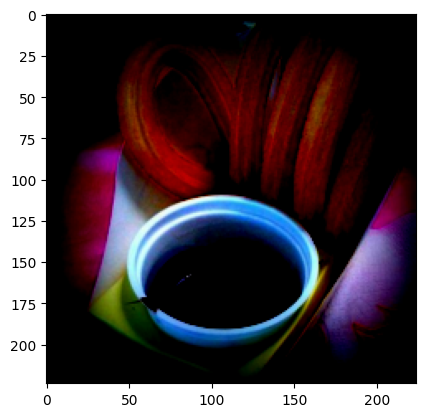

In [ ]:
# Run a prediction for an example image
sample = test_dataset[45]
image = sample["pixel_values"].numpy()
pred = lightning_vit.predict_step(torch.tensor(image).unsqueeze(0))
image = np.moveaxis(image, 0, -1)

label = labels[sample["labels"]]
plt.imshow(image)

print(f"Prediction: {pred}, real label: {label}")

In [ ]:
# (Optional) Upload your trained model to s3
# You can latter load it with:
# loaded_model = torch.load("./model.pt")
# loaded_model.eval()  # Run to finish loading the model
!pip install -Uqqq boto3
import boto3

model_file = "/content/lightning_logs/version_10/checkpoints/epoch=0-step=1184.ckpt"

s3 = boto3.client('s3', aws_access_key_id='XXXXXX', aws_secret_access_key='XXXXXX')
with open(model_file, "rb") as f:
    s3.upload_fileobj(f, "nico-ml-ops-course", "foodformer.pt")